<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
import warnings
#warnings.filterwarnings("ignore")
!pip install wandb -qq
import wandb
#from wandb.keras import WandbCallback

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Assignment_1", name="Question_1")

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

In [ ]:
#Load the fashion MNIST data 
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

#Normalize the data
x_train_full = x_train_full/255.0
x_test = x_test/255.0

#Splitting to get 10% data as validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=137)

y_train_unencoded = y_train
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()
y_val = encoder.fit_transform(np.expand_dims(y_val,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(y_test,1)).toarray()

In [ ]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train_unencoded, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

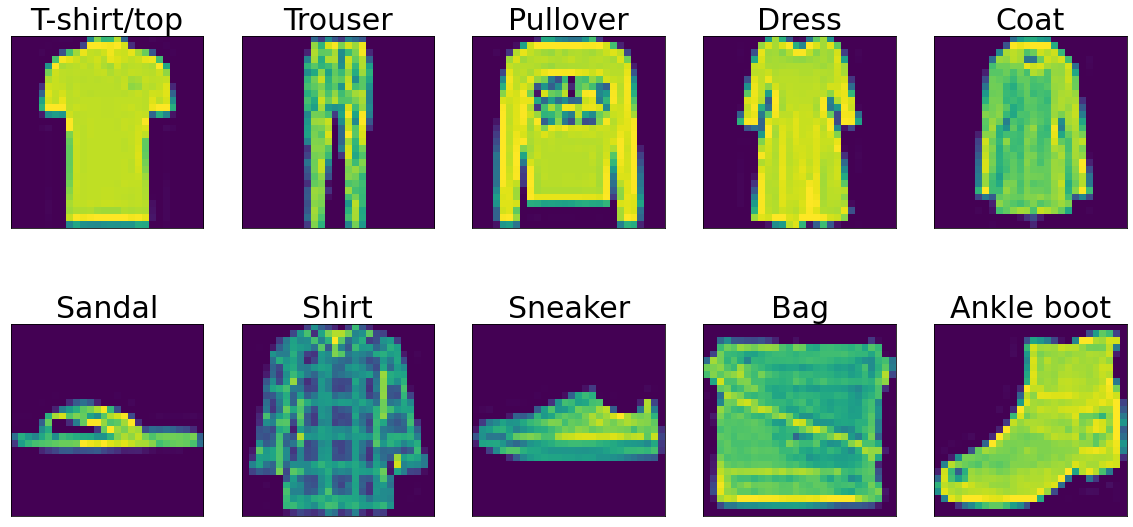

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"examples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.





In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, learning_rate):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.learning_rate = learning_rate
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))



  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def tanh_derivate(self,X):
    # Utility to compute tanh derivative
    return 1 - (np.tanh(X) ** 2)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def relu_derivative(self,X):
    # Utility to compute relu derivative
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')


    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def gradient_descent(self):
    for i in range(len(self.hidden_layer_sizes)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        self.weights[i+1] = self.weights[i+1] - self.learning_rate * self.dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        self.biases[i+1] = self.biases[i+1] - self.learning_rate * self.db[i+1]
    return 



  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()

model = FeedForwardNeuralNetwork([100,256, 512], 10, 0.0001)

model.fit(x_train[0:10000], y_encoded[0:10000])

Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
Epoch:  7  Loss:  194.9111013237063116
Epoch:  8  Loss:  202.96914933221613472
Epoch:  9  Loss:  242.3250418288858484


In [ ]:
#Check predictions for first 10 datapoints
for i in range(10):
  print(model.predict(x_train[i]))
  print(y_encoded[i])


[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Issue might be in sending dw_i to the functions (check call by value or call by reference)

##Question 3

In [ ]:
##Create classes for loss functions
#cross entropy loss

#Create classes for optimizers
#1.SGD
#2.NAG
#3.Momentum
#4.rmsprop
#7.adam
#6.nadam


In [ ]:
def accuracy(y_true, y_pred):
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random", log=0):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []
    self.log = log


  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    np.random.RandomState(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
        # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
        # Creates a row of biases corresponding to each weight of the layer

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    #self.H[0] = self.H[0].astype('float128')

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      #print("A :",np.isfinite(self.A[i+1]).all())
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])
      #print("H :",np.isfinite(self.H[i+1]).all())

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    #print("A :",np.isfinite(self.A[len(self.hidden_layer_sizes)+1]).all())
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    #print("H :",np.isfinite(self.H[len(self.hidden_layer_sizes)+1]).all())
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    #if self.loss_function.name() == "squared_loss":
    self.dA[len(self.hidden_layer_sizes)+1] = self.loss_function.last_output_derivative(self.H[len(self.hidden_layer_sizes)+1], Y, self.output_activation.compute_derivative(self.A[len(self.hidden_layer_sizes)+1]))
    #else:
    #  self.dA[len(self.hidden_layer_sizes)+1] = self.loss_function.last_output_derivative(self.H[len(self.hidden_layer_sizes)+1], Y) # -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      if i!=0:
        #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
        self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
        #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
        ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
        self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.A[i]), self.dH[i])    
    return dw_i, db_i


  def fit(self, X, Y, X_val, Y_val):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    #if self.optimizer.optimizer_name()=="nag":
    #  self.optimizer.set_model(self, X, Y)
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          #print("Done wih batch")
          count = 0
          if self.optimizer.optimizer_name()=="nag":
            w_lookahead = {}
            b_lookahead = {}
            for i in range(len(self.hidden_layer_sizes)+1):
              w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
              b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
            
            weights_old = self.weights
            biases_old = self.biases
            self.weights = w_lookahead
            self.biases = b_lookahead
            self.forward_propogation(x)
            dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
            self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

          else: 
            self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      if self.optimizer.optimizer_name()=="nag":
        w_lookahead = {}
        b_lookahead = {}
        for i in range(len(self.hidden_layer_sizes)+1):
          w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
          b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
        
        weights_old = self.weights
        biases_old = self.biases
        self.weights = w_lookahead
        self.biases = b_lookahead
        self.forward_propogation(x)
        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

      else:  
        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      #self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      training_loss = self.loss_function.compute_loss(Y, y_preds, self.batch_size)
      validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation, self.batch_size)
      training_accuracy = accuracy(np.argmax(Y,1), np.argmax(y_preds,1))
      validation_accuracy = accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
      if self.log==1:
        #Log metrics to wandb
        wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})

      print("Epoch: ",e+1," Training Loss: ",training_loss, " Validation Loss:",validation_loss ," Training Accuracy: ",training_accuracy, " Validation Accuracy:", validation_accuracy)
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def predict(self, X):
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


In [ ]:
class GD():
  def __init__(self, learning_rate = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.weight_decay = parameters["weight_decay"]

  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


class MomentumGD():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.weight_decay = weight_decay
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.weight_decay = parameters["weight_decay"]

    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class NAG():
  def __init__(self, learning_rate = 0.001, gamma = 0.9):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
    self.w_look_ahead={}
    self.b_look_ahead={}
    self.dw_look_ahead={}
    self.db_look_ahead={}
    #self.model = None
    #self.X = None
    #self.Y = None

  #def set_model(self, model, X, Y):
  #  self.model = model
  #  self.X = X
  #  self.Y = Y
  
  def optimizer_name(self):
    return "nag"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    self.dw_look_ahead.clear()
    self.db_look_ahead.clear()
    self.w_look_ahead.clear()
    self.b_look_ahead.clear()

    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.db_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))
      self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.b_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    
    #for i in range(len(layers)+1):
    #    self.w_look_ahead[i+1] = weights[i+1] - self.gamma*self.update_history_w[i+1]
    #    self.b_look_ahead[i+1] = biases[i+1] - self.gamma*self.update_history_b[i+1]

    #Compute backpropogation to obtain the gradients for lookahead parameters
    #self.dw_look_ahead, self.db_look_ahead = self.model.backward_propogation(self.X, self.Y, self.w_look_ahead, self.b_look_ahead)

    for i in range(len(layers)+1):

        self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]

        weights[i+1] = weights[i+1] - self.update_history_w[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, v_w = 0.001, v_b = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    # self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    # self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    #if self.initialized == False:
      #self.initialized = True
      #print(weights[1].shape[0])
      #print(weights[len(weights)].shape[-1])
      #all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
      #for i in range(len(layers)+1):
      #  self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      #  self.v_b[i+1] = np.zeros((1, all_layers[i+1]))

    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Adam():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "adam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(m_w_hat)
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(m_b_hat)

    self.iterations += 1
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


In [ ]:
class Sigmoid():
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    val = self.compute_activation(X)
    return val*(1-val)

class Softmax():
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    #Here X is the activation value
    softmax = self.compute_activation(X)
    return softmax*(1-softmax)

class Tanh():
  def compute_activation(self,X):
    return np.tanh(X)

  def compute_derivative(self,X):
    return 1 - (np.tanh(X) ** 2)

class ReLU():
  def compute_activation(self,X):
    return X * (X > 0)

  def compute_derivative(self,X):
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X

In [ ]:
class CrossEntropy():
  def compute_loss(self, Y_true, Y_pred, batch_size):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)

    #return (-np.sum(np.multiply(Y_true, np.log(Y_pred))))/batch_size
    return loss

  def name(self):
    return "cross_entropy_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

  def last_output_derivative(self, Y_pred,Y_true,activation_derivative):
    for p in Y_pred[0]:
      #print(p)
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return -(Y_true - Y_pred)


class SquaredErrorLoss():
  def compute_loss(self, Y_true, Y_pred, batch_size):
    #loss=np.multiply(Y_pred,Y_true)
    #loss=loss[loss!=0]
    #loss=-np.log(loss)
    #loss=np.mean(loss)

    return (1/2) * np.sum((Y_pred-Y_true)**2)/len(Y_true)
    #return loss

  def name(self):
    return "squared_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return (Y_pred)*(Y_pred-Y_true)/len(Y_true)

  def last_output_derivative(self, Y_pred,Y_true, activation_derivative):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return (Y_pred - Y_true)*activation_derivative/len(Y_true)

In [ ]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]


#all_layers = [x_train.shape[1]*x_train.shape[1]] + layers + [y_encoded.shape[1]]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "ReLU":ReLU()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8, "weight_decay":0.5}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.5}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]
activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
activation_relu = activation_functions["ReLU"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

#x_train = x_train.astype('float128')
model = FeedForwardNeuralNetwork(layers, optimizer_sgd, loss_squared, activation_tanh, output_activation_softmax, 5, 512, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.4087083810474027  Validation Loss: 0.366896297644663  Training Accuracy:  0.3954814814814815  Validation Accuracy: 0.5351666666666667
Epoch:  2  Training Loss:  0.33674837292953985  Validation Loss: 0.30761564810217856  Training Accuracy:  0.5490555555555555  Validation Accuracy: 0.5615
Epoch:  3  Training Loss:  0.29165770637016536  Validation Loss: 0.2764169721998846  Training Accuracy:  0.5791851851851851  Validation Accuracy: 0.5991666666666666
Epoch:  4  Training Loss:  0.2672150403412884  Validation Loss: 0.25841862873854227  Training Accuracy:  0.6169629629629629  Validation Accuracy: 0.629
Epoch:  5  Training Loss:  0.2519475207418422  Validation Loss: 0.24626332871963533  Training Accuracy:  0.6444814814814814  Validation Accuracy: 0.6505


(0.2519475207418422, 0.24626332871963533, 0.6444814814814814, 0.6505)

In [ ]:
#Accuracy for test data
y_preds = model.predict(x_test)
print(accuracy(np.argmax(y_test,1), np.argmax(y_preds,1)))

0.6503



Ref : https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

For Sigmoid/Tanh --> Use Xavier

Xavier Normal: For the normal distribution the limit value is constructed by averaging the Fin and Fout together and then taking the square-root (Jones, 2016). A zero-center (µ = 0) is then used:

Xavier Uniform: 

For Relu ---> Use He

##DEFAULT PARAMETERS:

GD : Learning_rate : 0.01

Momentum : Learning_rate : 0.001, gamma=0.9  (tune gamma with increments of 0.3)

NAG: Learning_rate : 0.001, gamma=0.9


In [ ]:
sweep_config = {
    #GridSearch over the hyperparameters
    'method': 'grid',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10, 15]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.0, 0.0005, 0.5]
        },
        'gamma': {
            'values': [0.3, 0.6, 0.9]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
        },
        'activation': {
            'values': ['sigmoid' , 'tanh', 'relu']
        },
        #'output_activation': {
        #    'values': ['softmax']
        #},
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64, 256, 512]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: bvwjknwo
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/bvwjknwo


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        'weight_decay' : 0.5,
        #'output_activation': 'softmax',
        'batch_size':100
    }

    '''
    # Initialize a new wandb run
    wandb.init(project='Assignment_1',config=config_defaults, name="Question_345")
    config = wandb.init().config
    '''
    
    with wandb.init(project='Assignment_1',config = sweep_config, name="Question_345"):
      config = wandb.init().config

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers' + str(len(config.hidden_layers)) + 'gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      weight_decay = config.weight_decay
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers

      if config.activation=="sigmoid":
        activation = activation_sigmoid
      
      if config.activation=="tanh":
        activation = activation_tanh

      if config.activation=="relu":
        activation = activation_relu
      #activation = config.activation

      #if config.output_activation=="softmax":
      #  output_activation = output_activation_softmax
      #output_activation = config.output_activation
      output_activation = output_activation_softmax

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_sgd)
        #optimizer = optimizer_sgd
      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_momentum)
        #optimizer = optimizer_momentum
      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer.set_initial_parameters(optimizer_parameters_nag)
        #optimizer = optimizer_nag
      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_rmsprop)
        #optimizer = optimizer_rmsprop
      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_adam)
        #optimizer = optimizer_adam
      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_nadam)
        #optimizer = optimizer_nadam
      #optimizer = config.optimizer
      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1)
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)
      del model

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id, train)

##Question 7: Best model

Fine tune to use a variant of Epoch:14, activation:tanh, optimizer:adam, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:64

In [ ]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

'''
#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.0}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.001, "gamma":0.9, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8, "weight_decay":0.5}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)
'''

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

'''
#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0005, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
'''

#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
#activation_sigmoid = activation_functions["sigmoid"]
#activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
#activation_relu = activation_functions["relu"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

model = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_cross_entropy, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.5906556086153221  Validation Loss: 0.45769211254103775  Training Accuracy:  0.7897037037037037  Validation Accuracy: 0.8263333333333334
Epoch:  2  Training Loss:  0.4189810735972017  Validation Loss: 0.40195854797093306  Training Accuracy:  0.847925925925926  Validation Accuracy: 0.8476666666666667
Epoch:  3  Training Loss:  0.3808704571518979  Validation Loss: 0.38035096344251657  Training Accuracy:  0.8622037037037037  Validation Accuracy: 0.8601666666666666
Epoch:  4  Training Loss:  0.35698552320487015  Validation Loss: 0.36359364526627524  Training Accuracy:  0.8708703703703704  Validation Accuracy: 0.868
Epoch:  5  Training Loss:  0.33913932867720065  Validation Loss: 0.35180295767897  Training Accuracy:  0.8773703703703704  Validation Accuracy: 0.8711666666666666
Epoch:  6  Training Loss:  0.3247543739892887  Validation Loss: 0.3434713700468033  Training Accuracy:  0.8824444444444445  Validation Accuracy: 0.8746666666666667
Epoch:  7  Training Loss: 

(0.2495761908604761, 0.3268266090997879, 0.9082037037037037, 0.884)

In [ ]:
#Accuracy for test data
y_pred = model.predict(x_test)
print(accuracy(np.argmax(y_test,1), np.argmax(y_pred,1)))

0.8756


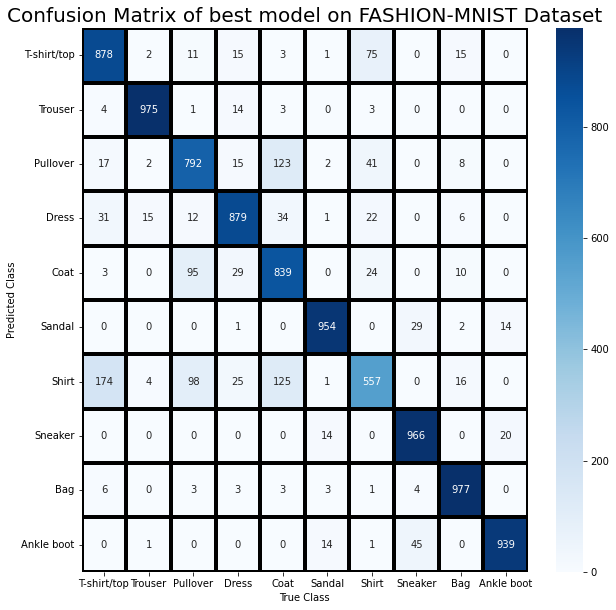

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wandb.init(project="Assignment_1", name="Question_7")

#labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

conf_matrix=metrics.confusion_matrix(np.argmax(y_test,1), np.argmax(y_pred,1))
df_conf_matrix = pd.DataFrame(conf_matrix, index=[i for i in labels], columns=[i for i in labels])

plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_conf_matrix, annot=True,  cmap='Blues', fmt='d',linewidths=3, linecolor='black')
ax.set_yticklabels(labels,rotation=0)
plt.xlabel("True Class")  
plt.ylabel("Predicted Class")
plt.title('Confusion Matrix of best model on FASHION-MNIST Dataset', fontsize=20)

wandb.log({"Confusion_matrix": wandb.Image(plt)})

plt.show()

wandb.finish()

##Question 8: Squared loss v/s Cross entropy loss

1. Obtain the list with validation losses and validation accuracy per epoch for validation set
2. Plot this as a comparison between the losses per epoch and accuracy per epoch for squared loss and cross entropy loss

In [ ]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

'''
#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.0}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.001, "gamma":0.9, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8, "weight_decay":0.5}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)
'''

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

'''
#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0005, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
'''

#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
#activation_sigmoid = activation_functions["sigmoid"]
#activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
#activation_relu = activation_functions["relu"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]


#wandb.init(project="Assignment_1", name="Question_8")

train_losses_crossentropy = []
train_accuracy_crossentropy = []
val_losses_crossentropy = []
val_accuracy_crossentropy = []

train_losses_squareloss = []
train_accuracy_squareloss = []
val_losses_squareloss = []
val_accuracy_squareloss = []

model_crossEnt = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_cross_entropy, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal", train_losses_list = train_losses_crossentropy, train_accuracy_list = train_accuracy_crossentropy, val_losses_list = val_losses_crossentropy, val_accuracy_list = val_accuracy_crossentropy)
model_squared = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_squared, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal", train_losses_list = train_losses_squareloss, train_accuracy_list = train_accuracy_squareloss, val_losses_list = val_losses_squareloss, val_accuracy_list = val_accuracy_squareloss)

model_crossEnt.fit(x_train, y_train, x_val, y_val)
model_squared.fit(x_train, y_train, x_val, y_val)



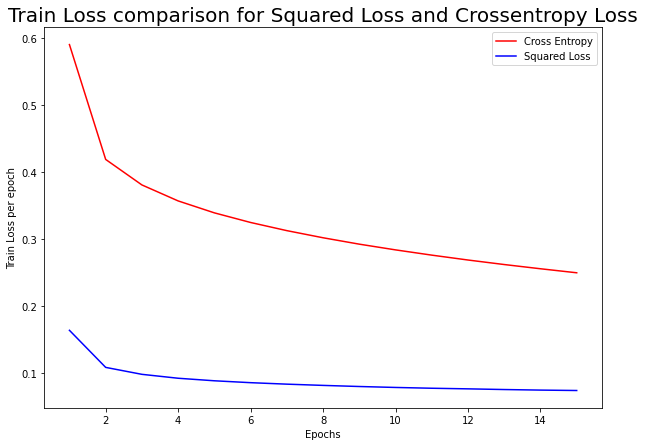

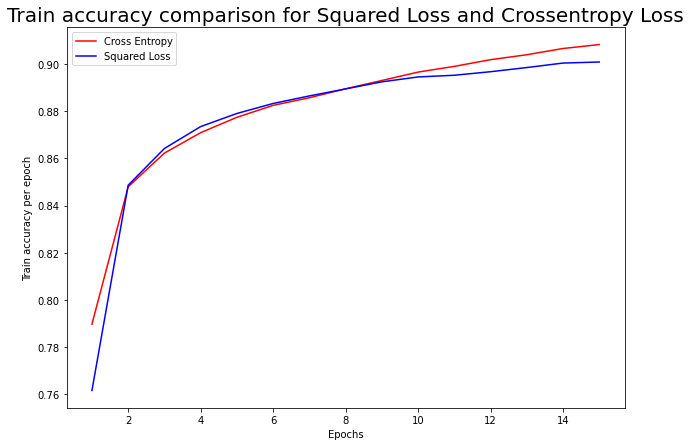

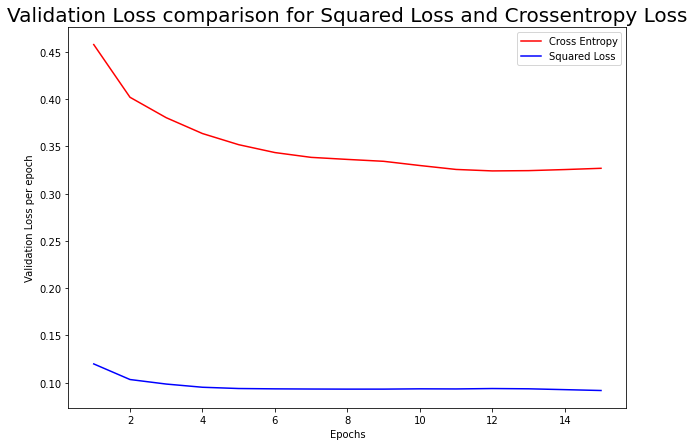

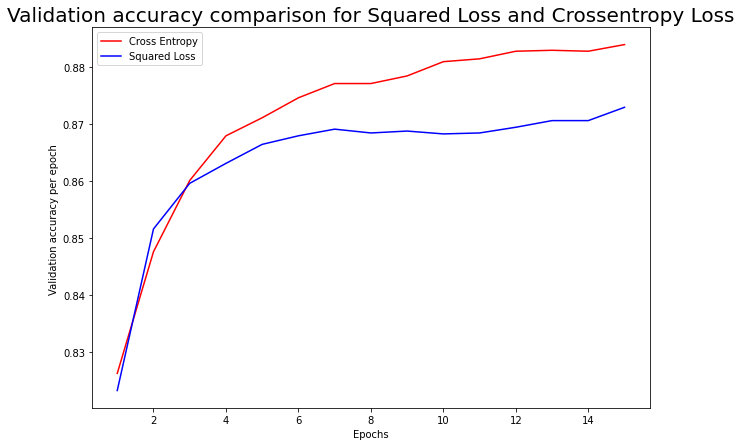

In [ ]:
wandb.init(project="Assignment_1", name="Question_8")

epochs = list(range(1, len(train_losses_squareloss)+1))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train Loss per epoch")
plt.title('Train Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train accuracy per epoch")
plt.title('Train accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation Loss per epoch")
plt.title('Validation Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation accuracy per epoch ")
plt.title('Validation accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



wandb.finish()

##Question 10: MNIST (Number) dataset classification using the top 3 hyperparameter sets from the models of Fashion MNIST

In [ ]:
from keras.datasets import mnist

(x_train_mnist_full, y_train_mnist_full), (x_test_mnist, y_test_mnist) = mnist.load_data()

#Normalize the data
x_train_mnist_full = x_train_mnist_full/255.0
x_test_mnist = x_test_mnist/255.0

#Splitting to get 10% data as validation set
x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(x_train_mnist_full, y_train_mnist_full, test_size=0.1, random_state=137)

y_train_mnist_unencoded = y_train_mnist
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train_mnist = encoder.fit_transform(np.expand_dims(y_train_mnist,1)).toarray()
y_val_mnist = encoder.fit_transform(np.expand_dims(y_val_mnist,1)).toarray()
y_test_mnist = encoder.fit_transform(np.expand_dims(y_test_mnist,1)).toarray()


In [ ]:
#MODEL 1: Epoch:15, activation:tanh, optimizer:adam, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:128

#MODEL 2: Epoch:15, activation:tanh, optimizer:sgd, layers : [32,64,128, 256], weight_decay:0, gamma:0.6, learning_rate:0.001, batch_size:32

#MODEL 3: Epoch:12, activation:tanh, optimizer:rmsprop, layers : [32,64,128], weight_decay:0, gamma:0.6, learning_rate:0.001, batch_size:32


In [ ]:
#Add layer sizes for the hidden layers
layers_3 = [32, 64, 128]
layers_4 = [32, 64, 128, 256]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

'''


#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.001, "gamma":0.9, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)


'''
#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.0}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.001, "gamma":0.6, "epsilon":1e-8, "weight_decay":0.0}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

'''
#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0005, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
'''

#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
#activation_sigmoid = activation_functions["sigmoid"]
#activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
#activation_relu = activation_functions["relu"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]





In [ ]:
model_mnist_1 = FeedForwardNeuralNetwork(layers_3, optimizer_adam, loss_cross_entropy, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal")
model_mnist_1.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.41073149293086636  Validation Loss: 0.22866350520259324  Training Accuracy:  0.8837592592592592  Validation Accuracy: 0.9336666666666666
Epoch:  2  Training Loss:  0.19884359980416677  Validation Loss: 0.16872381204267525  Training Accuracy:  0.940962962962963  Validation Accuracy: 0.9505
Epoch:  3  Training Loss:  0.14965588726762935  Validation Loss: 0.14585005882389732  Training Accuracy:  0.9555185185185185  Validation Accuracy: 0.9566666666666667
Epoch:  4  Training Loss:  0.12188738030480784  Validation Loss: 0.13561777810388953  Training Accuracy:  0.9635  Validation Accuracy: 0.9605
Epoch:  5  Training Loss:  0.102772847344875  Validation Loss: 0.13076245401588585  Training Accuracy:  0.9685925925925926  Validation Accuracy: 0.9618333333333333
Epoch:  6  Training Loss:  0.08830473422403737  Validation Loss: 0.12795487475558295  Training Accuracy:  0.9729814814814814  Validation Accuracy: 0.961
Epoch:  7  Training Loss:  0.07667572477647194  Validati

(0.02698002946049933,
 0.1541914689129405,
 0.9931666666666666,
 0.9633333333333334)

In [ ]:
model_mnist_2 = FeedForwardNeuralNetwork(layers_4, optimizer_sgd, loss_cross_entropy, activation_tanh, output_activation_softmax, 10, 32, initialization = "Xavier-Normal")
model_mnist_2.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.4047825036687557  Validation Loss: 0.2363341750042909  Training Accuracy:  0.8832962962962962  Validation Accuracy: 0.9295
Epoch:  2  Training Loss:  0.21450932676794235  Validation Loss: 0.17821919820261045  Training Accuracy:  0.9366111111111111  Validation Accuracy: 0.951
Epoch:  3  Training Loss:  0.16396836343485885  Validation Loss: 0.15192198489784853  Training Accuracy:  0.9513148148148148  Validation Accuracy: 0.9585
Epoch:  4  Training Loss:  0.13405215978408602  Validation Loss: 0.1384978450315099  Training Accuracy:  0.9598518518518518  Validation Accuracy: 0.9626666666666667
Epoch:  5  Training Loss:  0.11419506317920394  Validation Loss: 0.13113202845418856  Training Accuracy:  0.9658888888888889  Validation Accuracy: 0.9653333333333334
Epoch:  6  Training Loss:  0.09991556756453553  Validation Loss: 0.12683556940803298  Training Accuracy:  0.9702777777777778  Validation Accuracy: 0.9661666666666666
Epoch:  7  Training Loss:  0.088999068668429

(0.06570523724393633, 0.12096225777313425, 0.981, 0.9691666666666666)

In [ ]:
model_mnist_3 = FeedForwardNeuralNetwork(layers_3, optimizer_rmsprop, loss_cross_entropy, activation_tanh, output_activation_softmax, 12, 32, initialization = "Xavier-Normal")
model_mnist_3.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)


Epoch:  1  Training Loss:  0.33381318310126923  Validation Loss: 0.20253641383475854  Training Accuracy:  0.9003888888888889  Validation Accuracy: 0.9398333333333333
Epoch:  2  Training Loss:  0.1881230107996442  Validation Loss: 0.1598765639715446  Training Accuracy:  0.9439814814814815  Validation Accuracy: 0.9545
Epoch:  3  Training Loss:  0.1505517654384135  Validation Loss: 0.14564386897833984  Training Accuracy:  0.9551111111111111  Validation Accuracy: 0.9583333333333334
Epoch:  4  Training Loss:  0.1306969940512828  Validation Loss: 0.14045186956679195  Training Accuracy:  0.9618703703703704  Validation Accuracy: 0.9626666666666667
Epoch:  5  Training Loss:  0.11803450924758235  Validation Loss: 0.1371803743622551  Training Accuracy:  0.965925925925926  Validation Accuracy: 0.9621666666666666
Epoch:  6  Training Loss:  0.10921470393228362  Validation Loss: 0.13582253563987062  Training Accuracy:  0.9683703703703703  Validation Accuracy: 0.9635
Epoch:  7  Training Loss:  0.10234

(0.07937863683932539,
 0.13602860555992427,
 0.9777037037037037,
 0.9661666666666666)

In [ ]:
y_pred_mnist_1 = model_mnist_1.predict(x_test_mnist)
print("Test Accuracy for model 1:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_1,1)))

y_pred_mnist_2 = model_mnist_2.predict(x_test_mnist)
print("Test Accuracy for model 2:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_2,1)))

y_pred_mnist_3 = model_mnist_3.predict(x_test_mnist)
print("Test Accuracy for model 3:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_3,1)))


Test Accuracy for model 1: 0.9666
Test Accuracy for model 2: 0.9671
Test Accuracy for model 3: 0.9643
